# Boosting in Cox Regression

## Load libraries

In [1]:
## load the required packages

# clear all workspace
rm(list=ls()) 
# install the necessary packages
library("mlr3")
library("mlr3proba")
library("mlr3learners")
library("mlr3extralearners")
library("data.table")
library("mlr3viz")
library("mlr3tuning")
library("mlr3pipelines")
library("purrr")
library("mboost")
library("CoxBoost")
library("survival")
library("paradox")
library("ggrepel")
library("precrec")
library("ggplot2")
library("ggpubr")
library("tidyverse")
library("mlr3filters")
library("ranger")

NameError: name 'rm' is not defined

## Create the task for d4

In [3]:
# read in the raw data
train_data_original <- readRDS("~/Prediction_Challenge_T2E_ML/Data-20210107/train_data.Rds")

In [4]:
# get the corresponding dataframe1
train_data_d4 <- train_data_original$d4

In [5]:
## create the corresponding task as for dataframe 1
tsks_train_d4 <- TaskSurv$new("df4", backend = train_data_original$d4, time = "time", event = "status")
## check the task
tsks_train_d4

<TaskSurv:df1> (280 x 17)
* Target: time, status
* Properties: -
* Features (15):
  - dbl (11): V10, V11, V12, V13, V14, V3, V5, V6, V7, V8, V9
  - int (3): V1, V15, V2
  - fct (1): V4

## Hyperparameter Tuning for `d4`


In [6]:
## load the learner for the aft boosting and design the benchmark
## Step 1_1: Try with a default setting
design <- benchmark_grid(
  tasks = tsks_train_d4,
  learners = lrn("surv.mboost", baselearner = "bols", family = "weibull"), # cannot compute ‘bbs’ for non-numeric variables; used ‘bols’ instead.
  resampling = rsmp("cv", folds = 3L)
)


# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
aft_bmr <- run_benchmark(design)

INFO  [19:46:14.096] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [19:46:14.246] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 2/3) 
INFO  [19:46:14.747] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 3/3) 
INFO  [19:46:15.192] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 1/3) 
INFO  [19:46:15.659] [mlr3]  Finished benchmark 


In [7]:
# set the global evaluation metric
all_measures <- msr("surv.cindex")

# evaluate the performance with the IBS score
aft_results <- aft_bmr$aggregate(measures = all_measures)
aft_results # 0.8338

nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x5617bfdb5798>,df1,surv.mboost,cv,3,0.8337818


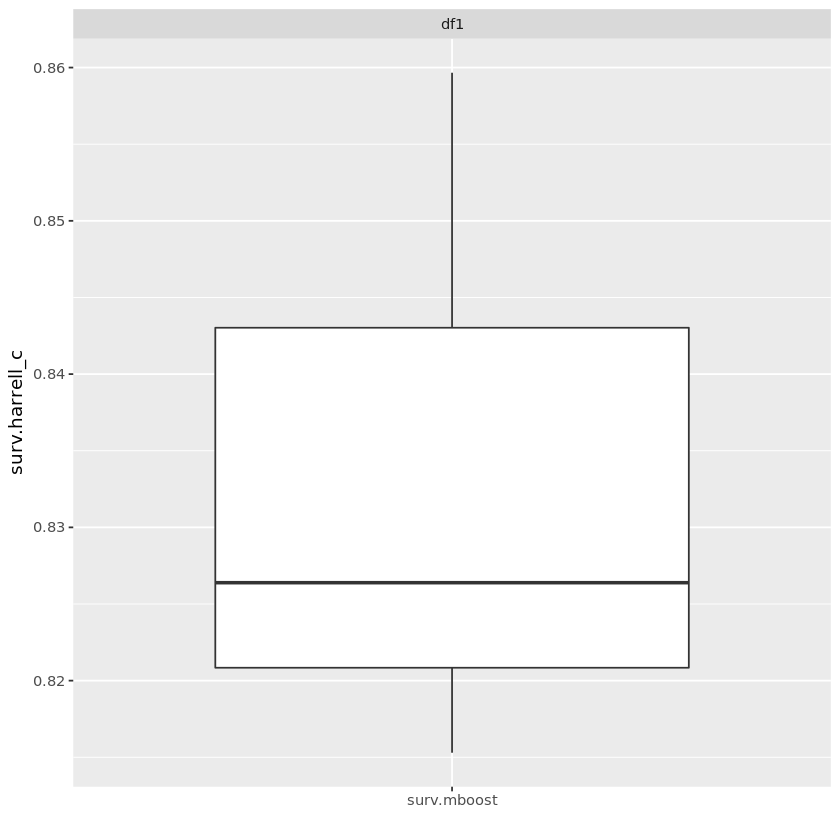

In [8]:
# plot the benchmark result with a default setting
autoplot(aft_bmr)

Step 1_2: Fine_tuning

In [9]:
# load the learner with aft
lrn_aft <- lrn("surv.mboost", baselearner = 'bols', family = "weibull")
# train with "baselearner"
base_learner_type <- c("bols", "btree")
family_type <- c("weibull", "loglog", "lognormal")

# set the search space
param_aft_bl <- ParamSet$new(params = list(
  ParamFct$new("baselearner", levels = base_learner_type),
  ParamFct$new("family", levels = family_type),
  ParamInt$new("mstop", lower = 50, upper = 150),
  ParamDbl$new("nu", lower = 0.1, upper = 0.2)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 4L)

# create the AutoTuner
grid_auto_aft <- AutoTuner$new(
  learner = lrn_aft, resampling = inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_aft_bl,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 5)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 3L)
# design the benchmark with bf
# design_aft_bl <- benchmark_grid(
#   tasks = tsks_train_d1,
#   learners = aft_bl,
#   resamplings = outer_rsmp
# )
aft_bmr_2 = resample(tsks_train_d4, grid_auto_aft, outer_rsmp, store_models = TRUE)



INFO  [19:46:46.084] [mlr3]  Applying learner 'surv.mboost.tuned' on task 'df1' (iter 3/3) 
INFO  [19:46:46.129] [bbotk] Starting to optimize 4 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [19:46:46.135] [bbotk] Evaluating 1 configuration(s) 
INFO  [19:46:46.165] [mlr3]  Benchmark with 4 resampling iterations 
INFO  [19:46:46.175] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 1/4) 
INFO  [19:46:46.515] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 2/4) 
INFO  [19:46:46.843] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 3/4) 
INFO  [19:46:47.218] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 4/4) 
INFO  [19:46:47.792] [mlr3]  Finished benchmark 
INFO  [19:46:47.842] [bbotk] Result of batch 1: 
INFO  [19:46:47.846] [bbotk]  baselearner  family mstop  nu surv.harrell_c 
INFO  [19:46:47.846] [bbotk]         bols weibull    67 0.1      0.8277571 
INFO  [19:46:47.846] [bbotk]                         

Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning 

In [18]:
# evaluate the performance
aft_bmr_2$aggregate(measures = msr("surv.cindex")) # 0.838

surv.harrell_c 
     0.8384477

In [25]:
## optimal hyperparameters found by grid search
aft_bmr_2$learners[[2]]$tuning_result$learner_param_vals

[[1]]
[[1]]$family
[1] "lognormal"

[[1]]$baselearner
[1] "bols"

[[1]]$mstop
[1] 65

[[1]]$nu
[1] 0.1

Step_1_3: Autoplot the pre and after results

In [31]:
# update the learners
lrn_aft_pre <- lrn("surv.mboost", baselearner = "bols", family = "weibull")
lrn_aft_after <- lrn("surv.mboost", baselearner = "bols", family = "lognormal", mstop = 65, nu = 0.1)
learners = list(lrn_aft_pre, lrn_aft_after)

# design <- benchmark_grid(
#   tasks = tsks_train_d1,
#   learners = learners,
#   resampling = rsmp("cv", folds = 3L)
# )
## run benchmark and save the results
aft_bmr_3 = benchmark(benchmark_grid(tsks_train_d4, learners, rsmp("cv", folds = 3L)))


INFO  [20:08:11.019] [mlr3]  Benchmark with 6 resampling iterations 
INFO  [20:08:11.028] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 3/3) 
INFO  [20:08:11.444] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 2/3) 
INFO  [20:08:11.718] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 2/3) 
INFO  [20:08:12.164] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 3/3) 
INFO  [20:08:12.450] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 1/3) 
INFO  [20:08:12.742] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 1/3) 
INFO  [20:08:13.169] [mlr3]  Finished benchmark 


In [32]:
aft_bmr_3

<BenchmarkResult> of 6 rows with 2 resampling runs
 nr task_id  learner_id resampling_id iters warnings errors
  1     df1 surv.mboost            cv     3        0      0
  2     df1 surv.mboost            cv     3        0      0

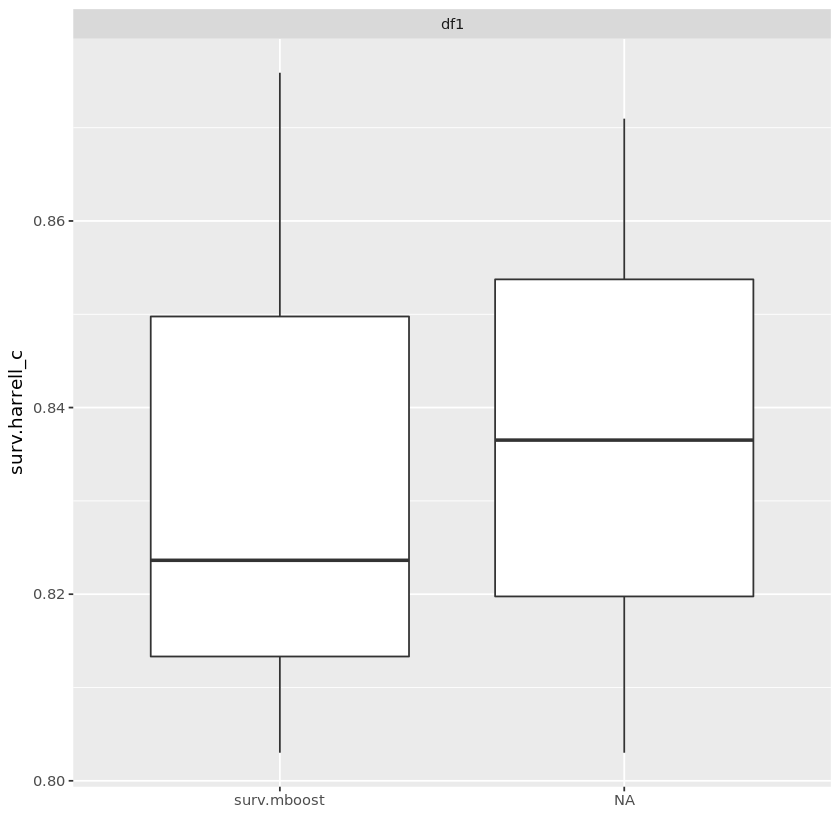

In [33]:
# autoplot the two boxplots
autoplot(aft_bmr_3)

#### Step 2: mboost
Step 2_1: Try with a default setting

In [38]:
design <- benchmark_grid(
  tasks = tsks_train_d4,
  learners = lrn("surv.mboost", baselearner = 'bols', family = "coxph"), # cannot compute ‘bbs’ for non-numeric variables; used ‘bols’ instead.
  resampling = rsmp("cv", folds = 3L)
)


# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
mb_bmr <- run_benchmark(design)

INFO  [20:12:01.914] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [20:12:01.922] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 2/3) 
INFO  [20:12:02.835] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 3/3) 
INFO  [20:12:03.793] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 1/3) 
INFO  [20:12:04.836] [mlr3]  Finished benchmark 


In [43]:
mb_bmr_results <- mb_bmr$aggregate(msr("surv.cindex"))
mb_bmr_results # 0.8306

nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x5617cd83b850>,df1,surv.mboost,cv,3,0.8306302


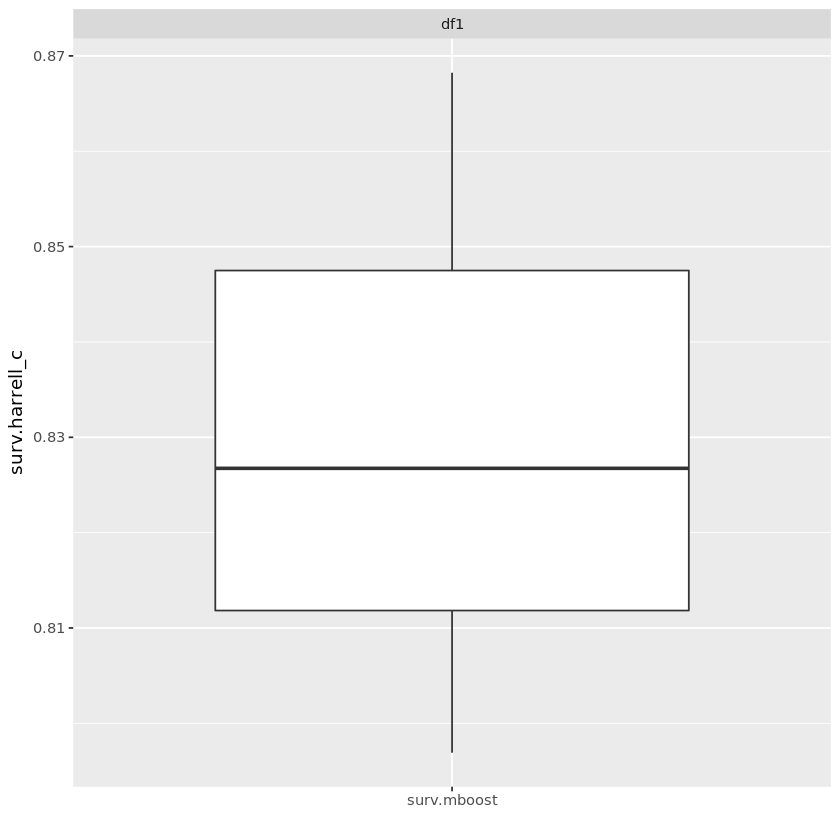

In [44]:
# plot the boxplots
autoplot(mb_bmr)

Step 2_2: Fine_tuning

In [45]:
# load the learner with mboost
lrn_mb <- lrn("surv.mboost", baselearner = 'bols', family = "coxph")
# train with "baselearner"
base_learner_type <- c("bols", "btree")
family_type <- c("cindex", "coxph")

# set the search space
param_mb <- ParamSet$new(params = list(
  ParamFct$new("baselearner", levels = base_learner_type),
  ParamFct$new("family", levels = family_type),
  ParamInt$new("mstop", lower = 160, upper = 180),
  ParamDbl$new("nu", lower = 0.16, upper = 0.3)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 4L)

# create the AutoTuner
grid_auto_mb <- AutoTuner$new(
  learner = lrn_mb, resampling = inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_mb,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 5)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 3L)
# design the benchmark with bf
# design_aft_bl <- benchmark_grid(
#   tasks = tsks_train_d1,
#   learners = aft_bl,
#   resamplings = outer_rsmp
# )
mb_bmr_2 = resample(tsks_train_d4, grid_auto_mb, outer_rsmp, store_models = TRUE)


INFO  [20:14:33.438] [mlr3]  Applying learner 'surv.mboost.tuned' on task 'df1' (iter 3/3) 
INFO  [20:14:33.471] [bbotk] Starting to optimize 4 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [20:14:33.476] [bbotk] Evaluating 1 configuration(s) 
INFO  [20:14:33.503] [mlr3]  Benchmark with 4 resampling iterations 
INFO  [20:14:33.512] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 3/4) 
INFO  [20:14:35.113] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 4/4) 
INFO  [20:14:36.697] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 2/4) 
INFO  [20:14:38.283] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 1/4) 
INFO  [20:14:39.890] [mlr3]  Finished benchmark 
INFO  [20:14:39.938] [bbotk] Result of batch 1: 
INFO  [20:14:39.940] [bbotk]  baselearner family mstop    nu surv.harrell_c 
INFO  [20:14:39.940] [bbotk]         bols cindex   165 0.195       0.816228 
INFO  [20:14:39.940] [bbotk]                       

In [46]:
# evaluate the performance
mb_bmr_2$aggregate() # 0.828

surv.harrell_c 
     0.8284672

In [54]:
## optimal hyperparameters found by grid search
mb_bmr_2$learners[[1]]$tuning_result$learner_param_vals

[[1]]
[[1]]$family
[1] "coxph"

[[1]]$baselearner
[1] "btree"

[[1]]$mstop
[1] 165

[[1]]$nu
[1] 0.23

Step_1_3: boxplot the pre and after

In [55]:
# update the learners
learners = list(lrn("surv.mboost", baselearner = "bols"),
               lrn("surv.mboost", baselearner = "btree", family = "coxph", mstop = 165, nu = 0.23))

design <- benchmark_grid(
  tasks = tsks_train_d4,
  learners = learners,
  resampling = rsmp("cv", folds = 3L)
)


# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
mb_bmr_3 <- run_benchmark(design)

INFO  [20:30:59.790] [mlr3]  Benchmark with 6 resampling iterations 
INFO  [20:30:59.798] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 3/3) 
INFO  [20:31:04.820] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 2/3) 
INFO  [20:31:05.829] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 3/3) 
INFO  [20:31:06.866] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 2/3) 
INFO  [20:31:11.848] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 1/3) 
INFO  [20:31:17.245] [mlr3]  Applying learner 'surv.mboost' on task 'df1' (iter 1/3) 
INFO  [20:31:18.295] [mlr3]  Finished benchmark 


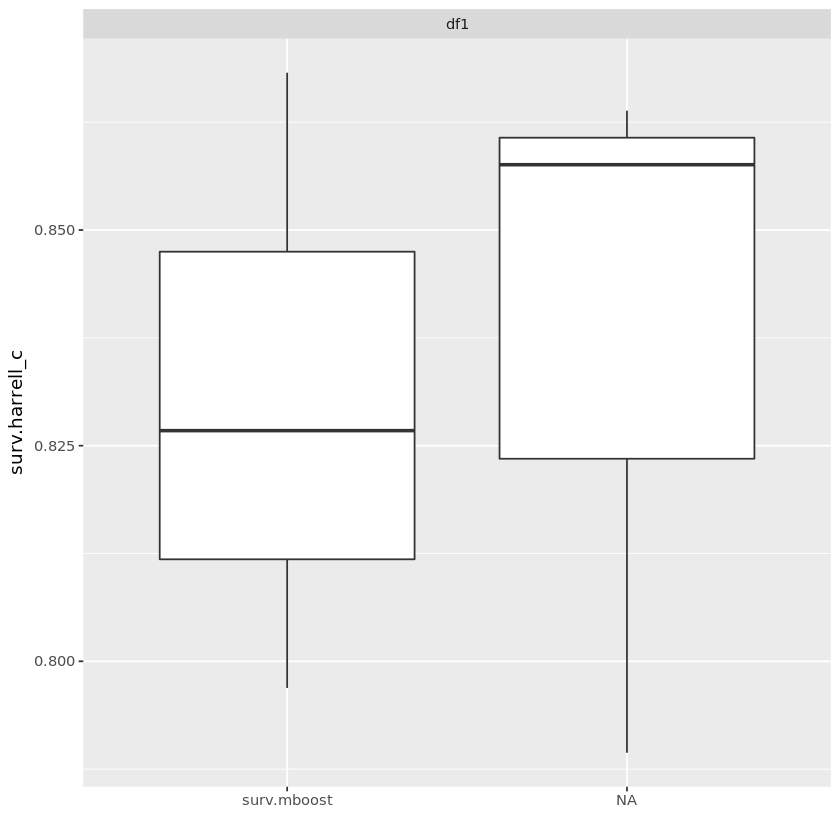

In [56]:
# autoplot the two boxplots
autoplot(mb_bmr_3)

#### Step 3: CoxBoost
Step 3_1: Data Preprocessing to encode the nominal variables

In [57]:
library("dataPreparation")
# Compute encoding
train_onehot_d4 <- train_data_d4
encoding <- build_encoding(train_onehot_d4, cols = c("V4"), verbose = TRUE)
# Apply one hot encoding
train_onehot_d4 <- one_hot_encoder(train_onehot_d4, encoding = encoding, drop = TRUE)
str(train_onehot_d4)

## create the corresponding task as for dataframe 1 after one-hot-encoding
tsks_oh_d4 <- TaskSurv$new("df4", backend = train_onehot_d4, time = "time", event = "status")
tsks_oh_d4

Loading required package: lubridate


Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: progress

dataPreparation 1.0.1

Type data_preparation_news() to see new features/changes/bug fixes.



[1] "build_encoding: I will compute encoding on 1 character and factor columns."
[1] "build_encoding: it took me: 0s to compute encoding for 1 character and factor columns."
[1] "one_hot_encoder: I will one hot encode some columns."
[1] "one_hot_encoder: I am doing column: V4"
[1] "one_hot_encoder: It took me 0s to transform 1 column(s)."
Classes ‘data.table’ and 'data.frame':	280 obs. of  18 variables:
 $ V1    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ time  : int  400 4500 1012 1925 1504 2503 1832 2466 2400 51 ...
 $ status: int  1 0 1 1 0 1 0 1 1 1 ...
 $ V2    : int  1 1 1 1 2 2 2 2 1 2 ...
 $ V3    : num  58.8 56.4 70.1 54.7 38.1 ...
 $ V5    : num  1 0 0.5 0.5 0 0 0 0 0 1 ...
 $ V6    : num  14.5 1.1 1.4 1.8 3.4 0.8 1 0.3 3.2 12.6 ...
 $ V7    : num  261 302 176 244 279 248 322 280 562 200 ...
 $ V8    : num  2.6 4.14 3.48 2.54 3.53 3.98 4.09 4 3.08 2.74 ...
 $ V9    : num  156 54 210 64 143 50 52 52 79 140 ...
 $ V10   : num  1718 7395 516 6122 671 ...
 $ V11   : num  137.9 113.5 96.1 

<TaskSurv:df1> (280 x 18)
* Target: time, status
* Properties: -
* Features (16):
  - dbl (11): V10, V11, V12, V13, V14, V3, V5, V6, V7, V8, V9
  - int (5): V1, V15, V2, V4.f, V4.m

Step 3_2: Try with a default setting

In [61]:
library("pracma")


Attaching package: ‘pracma’


The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu


The following object is masked from ‘package:purrr’:

    cross




In [62]:
install_learners('surv.coxboost')

In [63]:
design <- benchmark_grid(
  tasks = tsks_oh_d4,
  learners = lrn("surv.coxboost", criterion="hpscore"),
  resampling = rsmp("cv", folds = 3L)
)

# lrn("surv.coxboost")$param_set

# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
coxboost_bmr <- run_benchmark(design)


# set the global evaluation metric
all_measures <- msr("surv.cindex")

coxboost_results <- coxboost_bmr$aggregate(measures = all_measures)
coxboost_results # 0.836

INFO  [20:34:15.493] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [20:34:15.502] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 2/3) 
INFO  [20:34:17.167] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 3/3) 
INFO  [20:34:18.764] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 1/3) 
INFO  [20:34:20.462] [mlr3]  Finished benchmark 


nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x5617c690bd58>,df1,surv.coxboost,cv,3,0.8359983


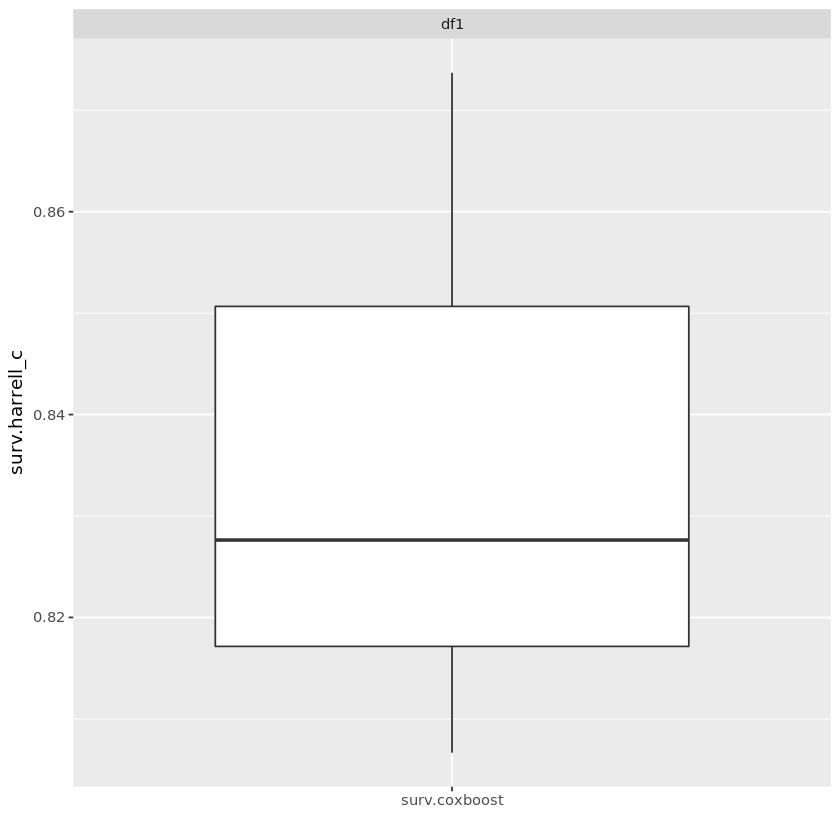

In [64]:
# plot the corresponding the performance
autoplot(coxboost_bmr)

Step_3_3: Fine-tuning with CoxBoost

In [82]:
# load the learner with CoxBoost
lrn_cb <- lrn("surv.coxboost", criterion="hpscore")
# from 50-250, 100-300, 150-250

# set the search space
param_cb <- ParamSet$new(params = list(
  ParamInt$new("stepno", lower = 50, upper = 250),
  ParamDbl$new("penalty", lower = 100, upper = 500),
  ParamDbl$new("stepsize.factor", lower = 0.1, upper = 10)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 4L)

# create the AutoTuner
grid_auto_cb <- AutoTuner$new(
  learner = lrn_cb, resampling =  inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_cb,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 5)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 3L)

cb_bmr_2 = resample(tsks_oh_d4, grid_auto_cb, outer_rsmp, store_models = TRUE)

INFO  [20:47:28.863] [mlr3]  Applying learner 'surv.coxboost.tuned' on task 'df1' (iter 3/3) 
INFO  [20:47:28.903] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [20:47:28.907] [bbotk] Evaluating 1 configuration(s) 
INFO  [20:47:28.935] [mlr3]  Benchmark with 4 resampling iterations 
INFO  [20:47:28.944] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 2/4) 
INFO  [20:47:29.701] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 3/4) 
INFO  [20:47:30.463] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 1/4) 
INFO  [20:47:31.243] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 4/4) 
INFO  [20:47:32.014] [mlr3]  Finished benchmark 
INFO  [20:47:32.060] [bbotk] Result of batch 1: 
INFO  [20:47:32.062] [bbotk]  stepno penalty stepsize.factor surv.harrell_c 
INFO  [20:47:32.062] [bbotk]      50     200            5.05      0.8302961 
INFO  [20:47:32.062] [bbotk]             

In [83]:
# evaluate the performance
cb_bmr_2$aggregate() # 0.84

surv.harrell_c 
     0.8400431

In [88]:
## optimal hyperparameters found by grid search
cb_bmr_2$learners[[1]]$tuning_result$learner_param_vals	

[[1]]
[[1]]$criterion
[1] "hpscore"

[[1]]$stepno
[1] 50

[[1]]$penalty
[1] 300

[[1]]$stepsize.factor
[1] 5.05

Step_3_4: Autoplot the pre and after tuning boxplots

In [89]:
# update the learners
learners = list(lrn("surv.coxboost", criterion="hpscore"),
               lrn("surv.coxboost", stepno=50, penalty=300, criterion="hpscore", stepsize.factor=5.05))

design <- benchmark_grid(
  tasks = tsks_oh_d4,
  learners = learners,
  resampling = rsmp("cv", folds = 3L)
)


# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
cb_bmr_3 <- run_benchmark(design)

INFO  [20:54:38.551] [mlr3]  Benchmark with 6 resampling iterations 
INFO  [20:54:38.560] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 3/3) 
INFO  [20:54:40.286] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 2/3) 
INFO  [20:54:41.971] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 3/3) 
INFO  [20:54:43.613] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 2/3) 
INFO  [20:54:45.296] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 1/3) 
INFO  [20:54:47.178] [mlr3]  Applying learner 'surv.coxboost' on task 'df1' (iter 1/3) 
INFO  [20:54:48.882] [mlr3]  Finished benchmark 


In [91]:
cb_bmr_3

<BenchmarkResult> of 6 rows with 2 resampling runs
 nr task_id    learner_id resampling_id iters warnings errors
  1     df1 surv.coxboost            cv     3        0      0
  2     df1 surv.coxboost            cv     3        0      0

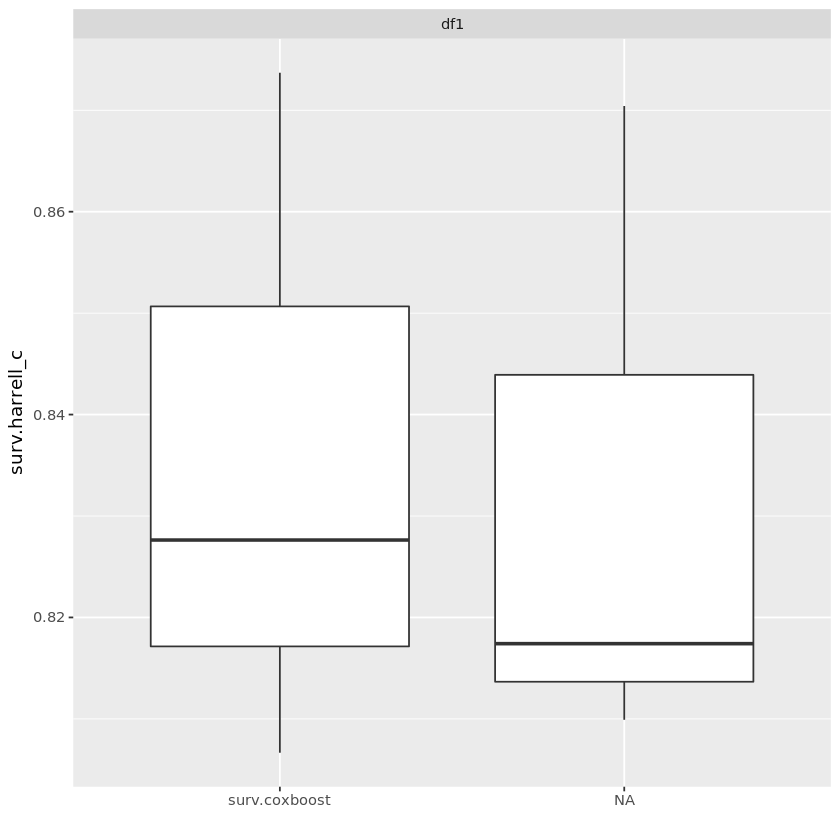

In [90]:
# autoplot the two boxplots
autoplot(cb_bmr_3)